In [1]:
import timm
import torch
import torch.optim as optim
import torchvision.utils as vutils
from torchvision import models
import torchvision.transforms as T
import torch.nn as nn
import torch.optim.lr_scheduler as lr_scheduler
from torch.utils.data import DataLoader, Dataset
from torch.nn import functional as F
import numpy as np
import pandas as pd
import os
from PIL import Image

import math
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, classification_report

from catboost import CatBoostClassifier

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [2]:
def imshow(img, mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)):
    """Imshow for Tensor."""
    img = img.numpy().transpose((1, 2, 0))
    # img = std * img + mean  # unnormalize
    # img = np.clip(img, 0, 1)  # clip any values outside the range [0, 1]
    plt.imshow(img)
    plt.show()

In [3]:
def plot_images_vs_reconstructed_images(images, reconstructed_imgs):
    # Move images back to cpu for visualization
    images = images.cpu()
    reconstructed_imgs = reconstructed_imgs.cpu()
    
    # Display original and reconstructed images
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    plt.title('Original Images')
    imshow(vutils.make_grid(images, padding=2, normalize=True))
    
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 2)
    plt.title('Reconstructed Images')
    imshow(vutils.make_grid(reconstructed_imgs, padding=2, normalize=True))

In [4]:
# TO CHANGE
class Encoder(nn.Module):
    def __init__(self, num_input_channels: int, base_channel_size: int, latent_dim: int, act_fn: object = nn.GELU):
        """Encoder.

        Args:
           num_input_channels : Number of input channels of the image. For CIFAR, this parameter is 3
           base_channel_size : Number of channels we use in the first convolutional layers. Deeper layers might use a duplicate of it.
           latent_dim : Dimensionality of latent representation z
           act_fn : Activation function used throughout the encoder network
        """
        super().__init__()
        c_hid = base_channel_size
        self.net = nn.Sequential(
            nn.Conv2d(num_input_channels, c_hid, kernel_size=3, padding=1, stride=2),  # 32x32 => 16x16
            act_fn(),
            nn.Conv2d(c_hid, c_hid, kernel_size=3, padding=1),
            act_fn(),
            nn.Conv2d(c_hid, 2 * c_hid, kernel_size=3, padding=1, stride=2),  # 16x16 => 8x8
            act_fn(),
            nn.Conv2d(2 * c_hid, 2 * c_hid, kernel_size=3, padding=1),
            act_fn(),
            nn.Conv2d(2 * c_hid, 2 * c_hid, kernel_size=3, padding=1, stride=2),  # 8x8 => 4x4
            act_fn(),
            nn.Flatten(),  # Image grid to single feature vector
            nn.Linear(8192, latent_dim),
        )

    def forward(self, x):
        return self.net(x)

encoder = Encoder(num_input_channels=3, base_channel_size = 64, latent_dim = 2000)
encoder = encoder.to(device)

In [5]:
class Decoder(nn.Module):
    def __init__(self, num_input_channels: int, base_channel_size: int, latent_dim: int, act_fn: object = nn.GELU):
        """Decoder.

        Args:
           num_input_channels : Number of channels of the image to reconstruct. For CIFAR, this parameter is 3
           base_channel_size : Number of channels we use in the last convolutional layers. Early layers might use a duplicate of it.
           latent_dim : Dimensionality of latent representation z
           act_fn : Activation function used throughout the decoder network
        """
        super().__init__()
        c_hid = base_channel_size
        self.linear = nn.Sequential(nn.Linear(latent_dim, 8192), act_fn())
        self.net = nn.Sequential(
            nn.ConvTranspose2d(
                2 * c_hid, 2 * c_hid, kernel_size=3, output_padding=1, padding=1, stride=2
            ),  # 4x4 => 8x8
            act_fn(),
            nn.Conv2d(2 * c_hid, 2 * c_hid, kernel_size=3, padding=1),
            act_fn(),
            nn.ConvTranspose2d(2 * c_hid, c_hid, kernel_size=3, output_padding=1, padding=1, stride=2),  # 8x8 => 16x16
            act_fn(),
            nn.Conv2d(c_hid, c_hid, kernel_size=3, padding=1),
            act_fn(),
            nn.ConvTranspose2d(
                c_hid, num_input_channels, kernel_size=3, output_padding=1, padding=1, stride=2
            ),  # 16x16 => 32x32
            nn.Tanh(),  # The input images is scaled between -1 and 1, hence the output has to be bounded as well
        )

    def forward(self, x):
        x = self.linear(x)
        x = x.reshape(x.shape[0], 128, 8, 8)
        x = self.net(x)
        return x

decoder = Decoder(num_input_channels=3, base_channel_size = 64, latent_dim = 2048)
decoder = decoder.to(device)

In [6]:
# class Decoder(nn.Module):
#     def __init__(self):
#         super(Decoder, self).__init__()
#         self.conv1 = nn.Conv2d(32, 192, kernel_size=1, padding=0)  # For 1x1 conv, padding is 0
#         self.upsample = nn.Upsample(scale_factor=2, mode='nearest')
#         self.conv2 = nn.Conv2d(192, 192, kernel_size=3, padding=1)  # padding changed to 1
#         self.conv3 = nn.Conv2d(192, 96, kernel_size=3, padding=1)  # padding changed to 1
#         self.conv4 = nn.Conv2d(96, 48, kernel_size=3, padding=1)  # padding changed to 1
#         self.conv5 = nn.Conv2d(48, 3, kernel_size=3, padding=1)  # padding changed to 1

#     def forward(self, x):
#         x = F.relu(self.conv1(x))
#         x = self.upsample(x)
#         x = F.relu(self.conv2(x))
#         x = self.upsample(x)
#         x = F.relu(self.conv3(x))
#         x = self.upsample(x)
#         x = F.relu(self.conv4(x))
#         decoded = torch.sigmoid(self.conv5(x))
#         return decoded

# class Decoder(nn.Module):
#     def __init__(self):
#         super(Decoder, self).__init__()
#         # Assuming latent_dim = 32 channels, and spatial dimensions 8x8 after the encoder
#         self.convtranspose1 = nn.ConvTranspose2d(32, 192, kernel_size=3, stride=2, padding=1, output_padding=1)  # 8x8 => 16x16
#         self.convtranspose2 = nn.ConvTranspose2d(192, 96, kernel_size=3, stride=2, padding=1, output_padding=1)  # 16x16 => 32x32
#         self.convtranspose3 = nn.ConvTranspose2d(96, 48, kernel_size=3, stride=2, padding=1, output_padding=1)  # 32x32 => 64x64
#         self.conv4 = nn.Conv2d(48, 3, kernel_size=3, padding=1)  # Final convolution to get to 3 channels

#     def forward(self, x):
#         x = F.relu(self.convtranspose1(x))
#         x = F.relu(self.convtranspose2(x))
#         x = F.relu(self.convtranspose3(x))
#         decoded = torch.sigmoid(self.conv4(x))
#         return decoded

# decoder = Decoder()
# decoder = decoder.to(device)

In [7]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Example usage
autoencoder = Autoencoder()
autoencoder = autoencoder.to(device)

In [8]:
# autoencoder.encoder = autoencoder.encoder.to(device)
# autoencoder.decoder = autoencoder.decoder.to(device)

### EDA 

In [9]:
train_df = pd.read_csv('dataset/train.csv')
valid_df = pd.read_csv('dataset/val.csv')
test_df = pd.read_csv('dataset/test.csv')

print(f"Train: {train_df.shape}; Valid: {valid_df.shape}; Test: {test_df.shape}")

Train: (13000, 2); Valid: (2000, 2); Test: (5000, 1)


In [10]:
train_df.columns, train_df.head()

(Index(['Image', 'Class'], dtype='object'),
                                       Image  Class
 0  0be195e0-eb16-4f29-ac7c-196dec9da47d.png     79
 1  28045419-b3b2-415b-9085-b4d241944235.png     94
 2  b7078f35-d239-4dd6-babb-1af7be1b9364.png     79
 3  0f54f663-2953-432b-bdd4-9b9f7a78bfb9.png     23
 4  ba11dda2-37d7-4d28-8bbb-128d452a171c.png     88)

In [11]:
train_path = 'dataset/train_images/'
val_path = 'dataset/val_images/'
test_path = 'dataset/test_images/'

In [12]:
train_image_path = os.path.join(train_path,train_df['Image'][0])
print(train_image_path)

dataset/train_images/0be195e0-eb16-4f29-ac7c-196dec9da47d.png


In [13]:
image = Image.open(train_image_path)
np.array(image).shape

(64, 64, 3)

### Data Setup

In [14]:
train_image_names = train_df['Image'].tolist()
train_image_labels = train_df['Class'].tolist()
# print(train_image_names[:5], train_image_labels[:5])

train_image_paths = [os.path.join(train_path, image_name)for image_name in train_image_names]
print(train_image_paths[:5], train_image_labels[:5])

['dataset/train_images/0be195e0-eb16-4f29-ac7c-196dec9da47d.png', 'dataset/train_images/28045419-b3b2-415b-9085-b4d241944235.png', 'dataset/train_images/b7078f35-d239-4dd6-babb-1af7be1b9364.png', 'dataset/train_images/0f54f663-2953-432b-bdd4-9b9f7a78bfb9.png', 'dataset/train_images/ba11dda2-37d7-4d28-8bbb-128d452a171c.png'] [79, 94, 79, 23, 88]


In [15]:
val_image_names = valid_df['Image'].tolist()
val_image_labels = valid_df['Class'].tolist()

val_image_paths = [os.path.join(val_path, image_name)for image_name in val_image_names]
print(val_image_paths[:5], val_image_labels[:5])

['dataset/val_images/e91a8fbc-d3ba-4b39-8c2f-04c14de78e5e.png', 'dataset/val_images/7c40819b-c3ce-4a91-9e98-c3df11b63623.png', 'dataset/val_images/d54269d7-fe86-4112-9c0f-99cc6ab8d9c0.png', 'dataset/val_images/cbf9ac9e-0859-4b54-ae65-347587b45deb.png', 'dataset/val_images/6aafce3f-9002-44e0-9a99-ffe9b49c9bac.png'] [32, 85, 41, 97, 62]


In [16]:
test_image_names = test_df['Image'].tolist()
test_image_paths = [os.path.join(test_path, image_name)for image_name in test_image_names]
print(test_image_paths[:5])

['dataset/test_images/046f61c4-b825-459a-8b2d-07503f5b94a5.png', 'dataset/test_images/67db001f-e287-4950-ac49-6683b493d1a4.png', 'dataset/test_images/9f1d36a1-f046-4c5d-9e8a-0a3758ff605c.png', 'dataset/test_images/5ffef91a-aaf9-4d0d-a219-83a9f5282361.png', 'dataset/test_images/c00af570-0000-4f8f-a3f2-c37a981bfdb1.png']


In [17]:
basic_transform = T.Compose([
    # T.Resize((64, 64)), # -> all are already 64 * 64
    T.ToTensor(),
    # T.Normalize([0.42835271, 0.40658227, 0.34071648], [0.2144312,  0.21884131, 0.20464434])
    T.Normalize((0.5,), (0.5,)),
])

In [18]:
# Function to process an image and get embedding
def get_embedding(image_path, encoder, flatten=True):
    image = Image.open(image_path)
    image = basic_transform(image).unsqueeze(0).to(device)  # Add batch dimension

    with torch.no_grad():
        embedding = encoder(image)
    
    if flatten:
        # Flatten the embedding
        embedding = torch.flatten(embedding, start_dim=0)
    
    return embedding

In [19]:
embedding = get_embedding(os.path.join(train_path, train_image_names[0]), encoder, flatten=False)
embedding.shape

torch.Size([1, 2048])

In [20]:
with torch.no_grad():
    reconstruction = decoder(embedding)
print(reconstruction.shape)

torch.Size([1, 3, 64, 64])


### Train AutoEncoder

In [43]:
train_transform = T.Compose([
    # T.RandomHorizontalFlip(p=0.5),
    # T.RandomVerticalFlip(p=0.5),
    # T.RandomRotation(30),
    # T.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5),
    T.ToTensor(),
    # T.Normalize([0.42835271, 0.40658227, 0.34071648], [0.2144312,  0.21884131, 0.20464434])
    T.Normalize((0.5,), (0.5,)),
])

In [22]:
# Example Dataset class
class CustomDataset(Dataset):
    def __init__(self, image_paths, labels, transform):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx])
        image = self.transform(image)
        label = self.labels[idx]
        return image, label

In [30]:
train_ae_dataset = CustomDataset(train_image_paths, train_image_labels, transform = train_transform)
train_ae_data_loader = DataLoader(train_ae_dataset, batch_size=128, shuffle=True, pin_memory=True)

In [31]:
criterion = nn.MSELoss(reduction='sum')
optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)

In [32]:
%%time
num_epochs = 100  # Number of epochs

for epoch in range(num_epochs):
    running_loss = 0.0
    autoencoder.train()
    for inputs, _ in train_ae_data_loader:
        optimizer.zero_grad()
        inputs = inputs.to(device)

        # Forward pass
        outputs = autoencoder(inputs)
        # print(outputs.shape)

        # Calculate the loss
        # loss = F.mse_loss(inputs, outputs, reduction="none")
        # loss = loss.sum(dim=[1, 2, 3]).mean(dim=[0])

        loss = criterion(inputs, outputs)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    if epoch % 10 == 0 and epoch != 0:
        # Save checkpoint
        checkpoint = {
            'epoch': epoch + 1,
            'encoder_state_dict': encoder.state_dict(),
            'decoder_state_dict': decoder.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': running_loss
        }
        torch.save(checkpoint, f'autoencoder_checkpoint_epoch_{epoch+1}.pth')
        
    # Print statistics
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_ae_data_loader)}')

print('Finished Training')

Epoch 1/100, Loss: 289045.56242340687
Epoch 2/100, Loss: 164879.04779411765
Epoch 3/100, Loss: 132378.57195925244
Epoch 4/100, Loss: 114219.93937653187
Epoch 5/100, Loss: 104087.10370710785
Epoch 6/100, Loss: 94741.26148897059
Epoch 7/100, Loss: 89739.93895526961
Epoch 8/100, Loss: 86243.49452359069
Epoch 9/100, Loss: 84094.4239430147
Epoch 10/100, Loss: 80737.02447150735
Epoch 11/100, Loss: 73412.75677849265
Epoch 12/100, Loss: 64350.95668658088
Epoch 13/100, Loss: 60352.029181985294
Epoch 14/100, Loss: 57547.65127144608
Epoch 15/100, Loss: 55643.07511871936
Epoch 16/100, Loss: 53372.95369944853
Epoch 17/100, Loss: 52111.12808287377
Epoch 18/100, Loss: 49206.549345128675
Epoch 19/100, Loss: 49142.35979626225
Epoch 20/100, Loss: 47923.114142922794
Epoch 21/100, Loss: 46211.8997778799
Epoch 22/100, Loss: 45535.6363549326
Epoch 23/100, Loss: 44112.43414905025
Epoch 24/100, Loss: 42695.738472732846
Epoch 25/100, Loss: 42627.51187193627
Epoch 26/100, Loss: 41591.36427696078
Epoch 27/100, L

#### Save Autoencoder

In [33]:
# # save encoder
# torch.save(autoencoder.encoder.state_dict(), 'autoencoder_enc_more_img_augs_v1_100e_bs_128_lr_0.001_train.pth')

#### Load Autoencoder
- deep_autoencoder_v1_40kloss -> on reconstruction, can essentially reconstruct a 64*64 image extremely well, almost perfectly - visually

In [180]:
autoencoder_chckpt = torch.load('autoencoder_checkpoint_epoch_41.pth')
print(autoencoder_chckpt.keys())

dict_keys(['epoch', 'encoder_state_dict', 'decoder_state_dict', 'optimizer_state_dict', 'loss'])


In [21]:
autoencoder_chckpt = torch.load('deep_autoencoder_v1_40kloss.pth')
print(autoencoder_chckpt.keys())

dict_keys(['epoch', 'encoder_state_dict', 'decoder_state_dict', 'optimizer_state_dict', 'loss'])


In [22]:
encoder.load_state_dict(autoencoder_chckpt['encoder_state_dict'])
# decoder.load_state_dict(autoencoder_chckpt['decoder_state_dict'])

<All keys matched successfully>

#### Viz Reconstruction Loss Train

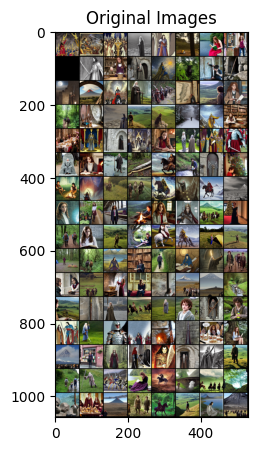

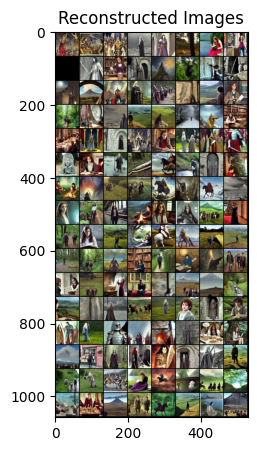

In [204]:
# Get a batch of images from your dataloader
dataiter = iter(train_data_loader) # or your specific dataloader
images, labels = next(dataiter)

# Move images to the device your model is on
images = images.to(device)

# Forward pass through encoder and then decoder
with torch.no_grad():  # We don't need to track gradients for the encoder
    latent_representation = encoder(images) # Get the last latent space representation
    reconstructed_imgs = decoder(latent_representation)

plot_images_vs_reconstructed_images(images, reconstructed_imgs)

#### Viz Reconstruction Loss Val

In [205]:
val_dataset = CustomDataset(val_image_paths, val_image_labels, transform = basic_transform)
val_data_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)

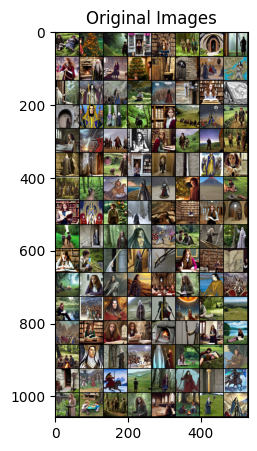

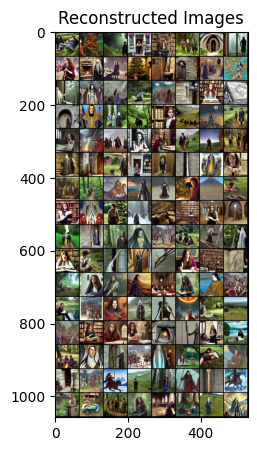

In [206]:
# Get a batch of images from your dataloader
dataiter = iter(val_data_loader) # or your specific dataloader
images, labels = next(dataiter)

# Move images to the device your model is on
images = images.to(device)

# Forward pass through encoder and then decoder
with torch.no_grad():  # We don't need to track gradients for the encoder
    latent_representation = encoder(images) # Get the last latent space representation
    reconstructed_imgs = decoder(latent_representation)

plot_images_vs_reconstructed_images(images, reconstructed_imgs)

#### Reconstruction Loss on Train

In [207]:
train_dataset = CustomDataset(train_image_paths, train_image_labels, transform = basic_transform)
train_data_loader = DataLoader(train_dataset, batch_size=128, shuffle=False)

In [208]:
total_loss = 0.0
total_batches = 0
with torch.no_grad():
    # No gradients needed for evaluation, which saves memory and computations
    for inputs, _ in train_data_loader:  # labels are not needed for loss computation
        # Move images to the device your model is on
        inputs = inputs.to(device)
    
        # Forward pass
        outputs = autoencoder(inputs)
    
        # Compute the reconstruction loss
        loss = F.mse_loss(outputs, inputs)
        
        # Accumulate the loss
        total_loss += loss.item()
        total_batches += 1
    
    # Calculate the average loss over all batches
    average_loss = total_loss / total_batches
    print(f'Average reconstruction loss on the train set: {average_loss}')

Average reconstruction loss on the train set: 0.020766204661306215


#### Reconstruction Loss on Validation

In [209]:
total_loss = 0.0
total_batches = 0
with torch.no_grad():
    # No gradients needed for evaluation, which saves memory and computations
    for inputs, _ in val_data_loader:  # labels are not needed for loss computation
        # Move images to the device your model is on
        inputs = inputs.to(device)
    
        # Forward pass
        outputs = autoencoder(inputs)
    
        # Compute the reconstruction loss
        loss = F.mse_loss(outputs, inputs)
        
        # Accumulate the loss
        total_loss += loss.item()
        total_batches += 1
    
    # Calculate the average loss over all batches
    average_loss = total_loss / total_batches
    print(f'Average reconstruction loss on the valid set: {average_loss}')

Average reconstruction loss on the valid set: 0.020761139690876007


#### Test Image reconstruction

In [148]:
# Example Dataset class
class TestDataset(Dataset):
    def __init__(self, image_paths, transform):
        self.image_paths = image_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx])
        image = self.transform(image)
        return image

In [149]:
test_dataset = TestDataset(test_image_paths, transform = basic_transform)
test_data_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

In [210]:
total_loss = 0.0
total_batches = 0
with torch.no_grad():
    # No gradients needed for evaluation, which saves memory and computations
    for inputs in test_data_loader:  # labels are not needed for loss computation
        # Move images to the device your model is on
        inputs = inputs.to(device)
    
        # Forward pass
        outputs = autoencoder(inputs)
    
        # Compute the reconstruction loss
        loss = F.mse_loss(outputs, inputs)
        
        # Accumulate the loss
        total_loss += loss.item()
        total_batches += 1
    
    # Calculate the average loss over all batches
    average_loss = total_loss / total_batches
    print(f'Average reconstruction loss on the test set: {average_loss}')

Average reconstruction loss on the test set: 0.020658136950805782


### Let's train the encoder on the labels now, given that

In [ ]:
# train_valid_img_paths = train_image_paths + val_image_paths
# train_valid_img_labels = train_image_labels + val_image_labels
# print(len(train_valid_img_paths), len(train_valid_img_labels))

In [23]:
train_enc_dataset = CustomDataset(train_image_paths, train_image_labels, transform = basic_transform)
train_enc_data_loader = DataLoader(train_enc_dataset, batch_size=128, shuffle=True, pin_memory=True)

In [24]:
# # Loss function and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(encoder.parameters(), lr=0.001)
# # scheduler = lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)

In [25]:
%%time
num_epochs = 100  # Number of epochs
# Loss function and optimizer
for epoch in range(num_epochs):
    running_loss = 0.0
    encoder.train()
    for inputs, labels in train_enc_data_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()

        # Forward pass
        outputs = encoder(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # scheduler.step()  # Update the learning rate

    # Print statistics
    avg_loss = running_loss / len(train_enc_data_loader)
    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {avg_loss:.4f}')

    if epoch % 5 == 0 and epoch != 0:
        # Save checkpoint
        checkpoint = {
            'epoch': epoch + 1,
            'model_state_dict': encoder.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': avg_loss,
        }
        torch.save(checkpoint, f'encoder_crossent_only_train_checkpoint_epoch_{epoch+1}.pth')

print('Finished Training')

Epoch 1/100, Loss: 4.4085
Epoch 2/100, Loss: 3.0335
Epoch 3/100, Loss: 2.2307
Epoch 4/100, Loss: 1.5128
Epoch 5/100, Loss: 0.8277
Epoch 6/100, Loss: 0.3005
Epoch 7/100, Loss: 0.1111
Epoch 8/100, Loss: 0.0584
Epoch 9/100, Loss: 0.0451
Epoch 10/100, Loss: 0.0503
Epoch 11/100, Loss: 0.0466
Epoch 12/100, Loss: 0.0395
Epoch 13/100, Loss: 0.0629
Epoch 14/100, Loss: 0.0693
Epoch 15/100, Loss: 0.0634
Epoch 16/100, Loss: 0.0501
Epoch 17/100, Loss: 0.0334
Epoch 18/100, Loss: 0.0323
Epoch 19/100, Loss: 0.0330
Epoch 20/100, Loss: 0.0310
Epoch 21/100, Loss: 0.0438
Epoch 22/100, Loss: 0.0467
Epoch 23/100, Loss: 0.0647
Epoch 24/100, Loss: 0.0527
Epoch 25/100, Loss: 0.0404
Epoch 26/100, Loss: 0.0440
Epoch 27/100, Loss: 0.0337
Epoch 28/100, Loss: 0.0230
Epoch 29/100, Loss: 0.0158
Epoch 30/100, Loss: 0.0121
Epoch 31/100, Loss: 0.0102
Epoch 32/100, Loss: 0.0353
Epoch 33/100, Loss: 0.0988


KeyboardInterrupt: 

In [ ]:
# Sanity check for train and valid embeddings

In [63]:
train_embeddings = [get_embedding(img_path, encoder).cpu() for img_path in train_image_paths]
val_embeddings = [get_embedding(img_path, encoder).cpu() for img_path in val_image_paths]
test_embeddings = [get_embedding(img_path, encoder).cpu() for img_path in test_image_paths]

In [26]:
# train_embeddings

#### Save Encoder after fine-tuning

In [60]:
# save encoder
torch.save(encoder.state_dict(), 'enc_crossent_train_valid_70e_bs_128_lr_0.001.pth')

#### Load Encoder after fine-tuning

In [28]:
encoder.load_state_dict(torch.load('encoder_crossent_only_train_checkpoint_epoch_31.pth')['model_state_dict']) # This also ruins it

<All keys matched successfully>

### Training Data

#### Catboost

In [29]:
train_embeddings = [get_embedding(img_path, encoder).cpu() for img_path in train_image_paths]
val_embeddings = [get_embedding(img_path, encoder).cpu() for img_path in val_image_paths]
test_embeddings = [get_embedding(img_path, encoder).cpu() for img_path in test_image_paths]

In [30]:
train_embeddings[:5]

[tensor([-29.8167, -17.7329, -19.1283,  ..., -27.4110, -27.1674, -26.8926]),
 tensor([-26.2161, -18.4823, -12.9043,  ..., -16.8917, -18.3195, -18.9698]),
 tensor([-30.0525, -21.5185, -28.7210,  ..., -35.7289, -34.0715, -34.1755]),
 tensor([-10.8419,  -8.2370, -11.3195,  ..., -25.2461, -25.3457, -25.6401]),
 tensor([-29.5201,  -9.5675, -24.8468,  ..., -34.3906, -34.0696, -33.0482])]

In [31]:
import pickle
# Store data (serialize) -> These are the reconstruction embeddings
with open('train_embeddings_encoder_crossent.pkl', 'wb') as handle:
    pickle.dump(train_embeddings, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('val_embeddings_encoder_crossent.pkl', 'wb') as handle:
    pickle.dump(val_embeddings, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('test_embeddings_encoder_crossent.pkl', 'wb') as handle:
    pickle.dump(test_embeddings, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [188]:
# Example embeddings and labels
X = np.array(train_embeddings)  # image_paths is a list of image file paths
y = np.array(train_image_labels)  # labels for each image

X_val = np.array(val_embeddings)
y_val = np.array(val_image_labels)

# Initialize CatBoost Classifier
# TODO: Add validation set and select best model, just to make sure we actually train properly
catboost_model = CatBoostClassifier(loss_function="MultiClass", task_type="GPU", iterations=1500)

# Train the model
catboost_model.fit(X, y, eval_set=(X_val, y_val))

Learning rate set to 0.114127
0:	learn: 4.4923410	test: 4.5063232	best: 4.5063232 (0)	total: 379ms	remaining: 9m 27s
1:	learn: 4.4044002	test: 4.4315840	best: 4.4315840 (1)	total: 757ms	remaining: 9m 27s
2:	learn: 4.3188669	test: 4.3595259	best: 4.3595259 (2)	total: 1.14s	remaining: 9m 28s
3:	learn: 4.2448732	test: 4.2934497	best: 4.2934497 (3)	total: 1.5s	remaining: 9m 22s
4:	learn: 4.1753573	test: 4.2372373	best: 4.2372373 (4)	total: 1.88s	remaining: 9m 21s
5:	learn: 4.1152242	test: 4.1865562	best: 4.1865562 (5)	total: 2.25s	remaining: 9m 20s
6:	learn: 4.0593675	test: 4.1393320	best: 4.1393320 (6)	total: 2.62s	remaining: 9m 18s
7:	learn: 4.0090736	test: 4.0942346	best: 4.0942346 (7)	total: 2.99s	remaining: 9m 17s
8:	learn: 3.9636905	test: 4.0595901	best: 4.0595901 (8)	total: 3.36s	remaining: 9m 16s
9:	learn: 3.9153936	test: 4.0193545	best: 4.0193545 (9)	total: 3.72s	remaining: 9m 14s
10:	learn: 3.8763942	test: 3.9902163	best: 3.9902163 (10)	total: 4.09s	remaining: 9m 13s
11:	learn: 3

#### Save Catboost Model

In [ ]:
import pickle

# Save the model to a file
with open('catboost_model.pkl', 'wb') as file:
    pickle.dump(catboost_model, file)

#### Loading the model

In [175]:
# Load the model from the file
with open('catboost_model.pkl', 'rb') as file:
    catboost_model = pickle.load(file)

FileNotFoundError: [Errno 2] No such file or directory: 'catboost_model.pkl'

#### Classifier

In [42]:
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.fc1 = nn.Linear(2048, 512)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, 256)
        self.dropout2 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(256, 100)  # 100 classes

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        x = F.log_softmax(self.fc3(x), dim=1)
        return x

In [ ]:
from torch.utils.data import TensorDataset, DataLoader

# Assuming X and y are your numpy arrays
X_tensor = torch.tensor(X).float()  # Convert X to a torch tensor and ensure it's of type float
y_tensor = torch.tensor(y).long()   # Convert y to a torch tensor and ensure it's of type long (for Cross-Entropy Loss)

# Create dataset and dataloader
dataset = TensorDataset(X_tensor, y_tensor)
data_loader = DataLoader(dataset, batch_size=64, shuffle=True)

# Instantiate model, loss function, and optimizer
clf = Classifier()
criterion_clf = nn.CrossEntropyLoss()
optimizer_clf = optim.Adam(clf.parameters(), lr=0.001)

In [47]:
# Training loop -> 150 epochs for 2048 emb dim
num_epochs = 50

for epoch in range(num_epochs):
    clf.train()  # Set the model to training mode
    running_loss = 0.0

    for inputs, labels in data_loader:
        optimizer_clf.zero_grad()  # Zero the parameter gradients

        # Forward pass
        outputs = clf(inputs)
        loss = criterion_clf(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer_clf.step()

        running_loss += loss.item()

    # Print statistics
    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {running_loss / len(data_loader)}')

print('Finished Training')

Epoch 1/50, Loss: 2.0621738328653225
Epoch 2/50, Loss: 2.0616320768992105
Epoch 3/50, Loss: 2.0617022607840743
Epoch 4/50, Loss: 2.056524287251865
Epoch 5/50, Loss: 2.062772359333786
Epoch 6/50, Loss: 2.048194604177101
Epoch 7/50, Loss: 2.047556222069497
Epoch 8/50, Loss: 2.044824436599133
Epoch 9/50, Loss: 2.031619937396517
Epoch 10/50, Loss: 2.0203114864872953
Epoch 11/50, Loss: 2.0220582666350344
Epoch 12/50, Loss: 2.0071793216116287
Epoch 13/50, Loss: 2.020677189616596
Epoch 14/50, Loss: 2.0271064446252933
Epoch 15/50, Loss: 1.9973555452683394
Epoch 16/50, Loss: 2.0082952123062285
Epoch 17/50, Loss: 2.0127001299577603
Epoch 18/50, Loss: 2.0066733962180567
Epoch 19/50, Loss: 1.9815474736924266
Epoch 20/50, Loss: 1.9864838590808944
Epoch 21/50, Loss: 2.010641942421595
Epoch 22/50, Loss: 1.9859233194706487
Epoch 23/50, Loss: 2.0104798446683323
Epoch 24/50, Loss: 1.9985341382961648
Epoch 25/50, Loss: 1.9784662028153737
Epoch 26/50, Loss: 1.9718919635987748
Epoch 27/50, Loss: 1.95496357

### Validation

#### Catboost

In [152]:
val_pred_labels = catboost_model.predict(val_embeddings)

#### Classifier

In [69]:
X_val = np.array(val_embeddings)
X_val_tensor = torch.tensor(X_val).float()

In [70]:
def get_predictions(model, data):
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():  # No need to track gradients during validation
        outputs = model(data)
        predicted_labels = torch.argmax(F.softmax(outputs, dim=1), dim=1)
    return predicted_labels.numpy()  # Convert to numpy array for comparison

# Get predictions for validation data
val_pred_labels = get_predictions(clf, X_val_tensor)
print(len(val_pred_labels))

2000


#### Accuracy Reports

In [189]:
accuracy = accuracy_score(val_image_labels, val_pred_labels)
print(f"Overall Accuracy: {accuracy * 100:.2f}%")

Overall Accuracy: 49.05%


In [190]:
# Generate the confusion matrix
cm = confusion_matrix(val_image_labels, val_pred_labels)

# Summing the diagonal elements gives the total number of correct predictions
correct_predictions = np.trace(cm)
total_predictions = cm.sum()

print(f"Number of Correct Predictions: {correct_predictions}")
print(f"Number of Incorrect Predictions: {total_predictions - correct_predictions}")

Number of Correct Predictions: 981
Number of Incorrect Predictions: 1019


### Train Encoder on Validation

In [156]:
val_dataset = CustomDataset(val_image_paths, val_image_labels, transform = basic_transform)
val_data_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)

In [159]:
criterion_enc_val = torch.nn.CrossEntropyLoss(reduction='sum')
optimizer_enc_val = torch.optim.Adam(encoder.parameters(), lr=0.0001)

In [160]:
%%time
num_epochs = 12  # Number of epochs
# Loss function and optimizer
for epoch in range(num_epochs):
    running_loss = 0.0
    encoder.train()
    for inputs, labels in val_data_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        criterion_enc_val.zero_grad()

        # Forward pass
        outputs = encoder(inputs)
        loss = criterion_enc_val(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer_enc_val.step()

        running_loss += loss.item()

    # scheduler.step()  # Update the learning rate

    # Print statistics
    avg_loss = running_loss / len(val_data_loader)
    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {avg_loss:.4f}')

    if epoch % 2 == 0 and epoch != 0:
        # Save checkpoint
        checkpoint = {
            'epoch': epoch + 1,
            'model_state_dict': encoder.state_dict(),
            'optimizer_state_dict': optimizer_enc_val.state_dict(),
            'loss': avg_loss,
        }
        torch.save(checkpoint, f'encoder_finetune_val_checkpoint_epoch_{epoch+1}.pth')

print('Finished Training')

Epoch 1/12, Loss: 917.5588
Epoch 2/12, Loss: 908.9466
Epoch 3/12, Loss: 903.7644
Epoch 4/12, Loss: 891.8743
Epoch 5/12, Loss: 903.3497
Epoch 6/12, Loss: 904.5974
Epoch 7/12, Loss: 897.4566
Epoch 8/12, Loss: 928.0888


KeyboardInterrupt: 

In [176]:
encoder.load_state_dict(torch.load('encoder_finetune_val_checkpoint_epoch_3.pth')['model_state_dict']) # This ruins it

<All keys matched successfully>

In [162]:
val_embeddings = [get_embedding(img_path, encoder, flatten=True).cpu() for img_path in val_image_paths]

In [163]:
X_val = np.array(val_embeddings)
y_val = np.array(val_image_labels)

In [166]:
catboost_model.fit(X_val, y_val)

Learning rate set to 0.04197
0:	learn: 4.6008145	total: 322ms	remaining: 10m 43s
1:	learn: 4.5916597	total: 596ms	remaining: 9m 55s
2:	learn: 4.5837437	total: 861ms	remaining: 9m 33s
3:	learn: 4.5779907	total: 1.13s	remaining: 9m 25s
4:	learn: 4.5704233	total: 1.43s	remaining: 9m 29s
5:	learn: 4.5625952	total: 1.7s	remaining: 9m 25s
6:	learn: 4.5560371	total: 2s	remaining: 9m 28s
7:	learn: 4.5500503	total: 2.29s	remaining: 9m 29s
8:	learn: 4.5437148	total: 2.56s	remaining: 9m 27s
9:	learn: 4.5363506	total: 2.84s	remaining: 9m 25s
10:	learn: 4.5321187	total: 3.16s	remaining: 9m 31s
11:	learn: 4.5272036	total: 3.48s	remaining: 9m 35s
12:	learn: 4.5201367	total: 3.76s	remaining: 9m 34s
13:	learn: 4.5135874	total: 4.04s	remaining: 9m 33s
14:	learn: 4.5110566	total: 4.3s	remaining: 9m 29s
15:	learn: 4.5070508	total: 4.56s	remaining: 9m 25s
16:	learn: 4.5024800	total: 4.83s	remaining: 9m 23s
17:	learn: 4.4970103	total: 5.13s	remaining: 9m 24s
18:	learn: 4.4919805	total: 5.4s	remaining: 9m 22

### Predict on Test

In [191]:
test_embeddings = [get_embedding(img_path, encoder).cpu() for img_path in test_image_paths]

In [192]:
# test the order
print(test_image_paths[:5])
print()
print(test_df['Image'][:5])

['dataset/test_images/046f61c4-b825-459a-8b2d-07503f5b94a5.png', 'dataset/test_images/67db001f-e287-4950-ac49-6683b493d1a4.png', 'dataset/test_images/9f1d36a1-f046-4c5d-9e8a-0a3758ff605c.png', 'dataset/test_images/5ffef91a-aaf9-4d0d-a219-83a9f5282361.png', 'dataset/test_images/c00af570-0000-4f8f-a3f2-c37a981bfdb1.png']

0    046f61c4-b825-459a-8b2d-07503f5b94a5.png
1    67db001f-e287-4950-ac49-6683b493d1a4.png
2    9f1d36a1-f046-4c5d-9e8a-0a3758ff605c.png
3    5ffef91a-aaf9-4d0d-a219-83a9f5282361.png
4    c00af570-0000-4f8f-a3f2-c37a981bfdb1.png
Name: Image, dtype: object


In [193]:
X_test = np.array(test_embeddings)

In [194]:
y_test = catboost_model.predict(X_test)

In [195]:
test_df['Class'] = y_test

In [196]:
test_df.head()

,Image,Class
0,046f61c4-b825-459a-8b2d-07503f5b94a5.png,48
1,67db001f-e287-4950-ac49-6683b493d1a4.png,91
2,9f1d36a1-f046-4c5d-9e8a-0a3758ff605c.png,40
3,5ffef91a-aaf9-4d0d-a219-83a9f5282361.png,51
4,c00af570-0000-4f8f-a3f2-c37a981bfdb1.png,69


In [197]:
test_df.to_csv('submission_autoenc_v1_no_ft_emb_2048.csv', index=False)